Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [101]:
HYPERTRAINING = False
CV = 5
SCORING = 'recall_micro'
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_predictor"
RUN_NAME = None

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 'shooting_technique',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [  'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility','Composure', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']


In [102]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [103]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>=84)
GROUP BY ID
order by potential DESC;
"""



In [104]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense,overall_age_ratio,youth_player,shooting,shooting_technique,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,€0,2121.0,"RW,RF,ST,CAM",11360.0,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0,0.170132,False,87.666667,85.4,NaN,67.0,91.0,94.2,12.661765,-5.705882,22.544118,-0.147059,26.102941,18.691176,30.102941,22.323529
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,€0,2223.0,"RW,CAM,LW,ST",11359.0,84.0,89.0,87.0,81.0,85.0,93.0,88.0,88.0,71.0,95.0,93.0,94.0,94.0,88.0,84.0,93.0,91.0,85.0,80.0,91.0,61.0,24.0,88.0,80.0,82.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0,0.142400,False,88.333333,89.2,NaN,82.5,93.5,92.2,10.795455,7.250000,26.595455,9.863636,26.750000,7.522727,31.409091,23.522727
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,€105K,1911.0,"RW,LW,CAM",12092.0,69.0,73.0,66.0,71.0,66.0,85.0,84.0,56.0,67.0,83.0,81.0,78.0,83.0,79.0,67.0,74.0,63.0,77.0,71.0,74.0,53.0,32.0,74.0,75.0,67.0,NaN,34.0,32.0,5.0,9.0,6.0,15.0,7.0,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0,0.195000,False,67.666667,68.6,75.5,74.0,79.5,80.2,5.823529,7.441176,9.552941,4.823529,6.941176,6.176471,10.823529,7.058824
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,€0,1958.0,"RW,LW,CF,RM",11226.0,74.0,76.0,64.0,80.0,67.0,84.0,68.0,64.0,68.0,86.0,87.0,86.0,83.0,78.0,76.0,72.0,67.0,74.0,56.0,74.0,54.0,42.0,80.0,82.0,75.0,35.0,32.0,29.0,11.0,12.0,6.0,8.0,8.0,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0,0.224377,True,73.333333,70.6,NaN,65.0,86.5,83.0,8.518519,-2.129630,10.822222,4.592593,15.925926,16.851852,15.555556,14.148148
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,€90K,1929.0,"RW,LW",12571.0,72.0,78.0,62.0,73.0,67.0,84.0,80.0,73.0,57.0,80.0,88.0,86.0,87.0,78.0,85.0,71.0,73.0,81.0,45.0,71.0,54.0,21.0,83.0,71.0,74.0,NaN,36.0,32.0,9.0,8.0,12.0,8.0,5.0,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0,0.218837,True,78.000000,72.0,78.0,63.0,87.0,83.2,12.611111,0.444444,17.855556,12.055556,20.555556,7.777778,19.888889,8.055556


# 

In [105]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'test', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<84)&(df.Age<26)&(df.Potential>=84)]

In [106]:

df = df[df.prime_age>df.potential_age]
df['target'] = df.PrimeOverall>82
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()
df_processed.head()

target
False    229
True      96
Name: count, dtype: int64


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense,overall_age_ratio,youth_player,shooting,shooting_technique,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,set,target
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,€0,2121.0,"RW,RF,ST,CAM",11360.0,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0,0.170132,False,87.666667,85.4,NaN,67.0,91.0,94.2,12.661765,-5.705882,22.544118,-0.147059,26.102941,18.691176,30.102941,22.323529,drop,True
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,€0,2223.0,"RW,CAM,LW,ST",11359.0,84.0,89.0,87.0,81.0,85.0,93.0,88.0,88.0,71.0,95.0,93.0,94.0,94.0,88.0,84.0,93.0,91.0,85.0,80.0,91.0,61.0,24.0,88.0,80.0,82.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0,0.142400,False,88.333333,89.2,NaN,82.5,93.5,92.2,10.795455,7.250000,26.595455,9.863636,26.750000,7.522727,31.409091,23.522727,drop,True
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,€0,1958.0,"RW,LW,CF,RM",11226.0,74.0,76.0,64.0,80.0,67.0,84.0,68.0,64.0,68.0,86.0,87.0,86.0,83.0,78.0,76.0,72.0,67.0,74.0,56.0,74.0,54.0,42.0,80.0,82.0,75.0,35.0,32.0,29.0,11.0,12.0,6.0,8.0,8.0,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0,0.224377,True,73.333333,70.6,NaN,65.0,86.5,83.0,8.518519,-2.129630,10.822222,4.592593,15.925926,16.851852,15.555556,14.148148,drop,True
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,€90K,1929.0,"RW,LW",12571.0,72.0,78.0,62.0,73.0,67.0,84.0,80.0,73.0,57.0,80.0,88.0,86.0,87.0,78.0,85.0,71.0,73.0,81.0,45.0,71.0,54.0,21.0,83.0,71.0,74.0,NaN,36.0,32.0,9.0,8.0,12.0,8.0,5.0,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0,0.218837,True,78.000000,72.0,78.0,63.0,87.0,83.2,12.611111,0.444444,17.855556,12.055556,20.555556,7.777778,19.888889,8.055556,test,False
208790,Z. Bakkali,2014,17.0,17.0,https://cdn.sofifa.net/players/208/790/14_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,73.0,90.0,PSV,https://cdn.sofifa.net/meta/team/682/30.png,€2.1M,€30K,1734.0,"RW,LW",9423.0,64.0,64.0,27.0,62.0,69.0,86.0,74.0,67.0,52.0,78.0,87.0,83.0,87.0,66.0,92.0,69.0,68.0,57.0,30.0,72.0,36.0,25.0,65.0,67.0,56.0,25.0,25.0,25.0,10.0,5.0,15.0,11.0,15.0,NaN,NaN,90.0,20.0,74.0,RW,0,1,1.0,25.0,0.252595,True,65.333333,68.2,NaN,43.5,85.0,84.2,6.166667,-9.500000,16.500000,-1.833333,10.666667,10.000000,12.666667,5.500000,train,False


In [107]:
df_processed.best_position.value_counts()

best_position
ST    163
LW     66
RW     61
CF     27
LF      4
RF      4
Name: count, dtype: int64

In [108]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,True,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,True,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,True,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,False,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,False,train,RW


In [109]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [110]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head(100)

youth_player        -0.26
overall_age_ratio   -0.20
central             -0.04
Defense             -0.04
GKReflexes          -0.02
                     ... 
Reactions            0.50
Overall              0.52
PrimeOverall         0.76
target               1.00
offense               NaN
Name: target, Length: 65, dtype: float64

In [111]:
df[df.Age<20].describe().round(0).compare(df[df.Age>=20].describe().round(0))

potential_age           Age        Overall        Potential         \
               self  other   self  other    self  other      self  other   
count         139.0  186.0  139.0  186.0   139.0  186.0     139.0  186.0   
mean           18.0   22.0   18.0   22.0    70.0   77.0       NaN    NaN   
std             1.0    2.0    1.0    2.0     NaN    NaN       NaN    NaN   
min            16.0   20.0   16.0   20.0    59.0   67.0       NaN    NaN   
25%            18.0   21.0   18.0   21.0    67.0   74.0       NaN    NaN   
50%            18.0   22.0   18.0   22.0    69.0   77.0       NaN    NaN   
75%            19.0   23.0   19.0   23.0    73.0   80.0       NaN    NaN   
max            19.0   25.0   19.0   25.0    81.0   90.0      91.0   95.0   

      Special         Unnamed: 0          Crossing        Finishing         \
         self   other       self    other     self  other      self  other   
count   139.0   186.0      139.0    186.0    139.0  186.0     139.0  186.0   
mean   1691.0  1884.0     9038.0  11336.0     56.0   66.0      68.0   76.0   
std     117.0   122.0     2697.0   1765.0     12.0   13.0       6.0    7.0   
min    1424.0  1531.0     2018.0   7608.0     28.0   22.0      50.0   57.0   
25%    1604.0  1810.0     7288.0  10342.0     46.0   60.0      65.0   71.0   
50%    1692.0  1884.0     8949.0  11134.0     57.0   68.0      68.0   76.0   
75%    1757.0  1960.0    10640.0  11866.0     65.0   74.0      72.0   82.0   
max    1979.0  2316.0    16494.0  17353.0     78.0   89.0      85.0   92.0   

      HeadingAccuracy        ShortPassing        Volleys        Dribbling  \
                 self  other         self  other    self  other      self   
count           139.0  186.0        139.0  186.0   139.0  186.0     139.0   
mean             57.0   64.0         63.0   72.0    60.0   70.0      73.0   
std              11.0   13.0          8.0    6.0     8.0    9.0       NaN   
min              17.0   29.0         40.0   48.0    40.0   36.0      55.0   
25%              50.0   56.0         58.0   68.0    56.0   65.0      68.0   
50%              60.0   67.0         64.0   72.0    61.0   70.0      74.0   
75%              65.0   74.0         69.0   76.0    66.0   76.0      77.0   
max              78.0   92.0         82.0   89.0    81.0   91.0      87.0   

              Curve        FKAccuracy        LongPassing        BallControl  \
       other   self  other       self  other        self  other        self   
count  186.0  139.0  186.0      139.0  186.0       139.0  186.0       139.0   
mean    79.0   60.0   68.0       51.0   60.0        52.0   60.0        72.0   
std      NaN   12.0   11.0       12.0   14.0        10.0   11.0         NaN   
min     58.0   33.0   32.0       29.0   26.0        30.0   28.0        51.0   
25%     74.0   52.0   63.0       42.0   49.0        44.0   52.0        68.0   
50%     79.0   62.0   69.0       51.0   60.0        51.0   60.0        72.0   
75%     84.0   68.0   76.0       59.0   72.0        60.0   68.0        76.0   
max     97.0   81.0   88.0       81.0   88.0        71.0   84.0        86.0   

             Acceleration        SprintSpeed        Agility        Reactions  \
       other         self  other        self  other    self  other      self   
count  186.0        139.0  186.0       139.0  186.0   139.0  186.0     139.0   
mean    79.0         80.0   83.0        80.0   82.0    77.0   80.0      65.0   
std      NaN          NaN    NaN         NaN    NaN     NaN    NaN       8.0   
min     65.0         55.0   62.0        55.0   60.0    50.0   58.0      46.0   
25%     75.0         76.0   79.0        76.0   78.0    72.0   75.0      60.0   
50%     78.0         80.0   84.0        80.0   82.0    77.0   80.0      65.0   
75%     82.0         86.0   87.0        85.0   86.0    82.0   86.0      70.0   
max     96.0          NaN    NaN        93.0   94.0    95.0   96.0      86.0   

             Balance        ShotPower        Jumping        Stamina         \
       other    self  o

In [112]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
bool_age = df.Age == 20
df[df.target&bool_age].describe().round(3).compare(df[~df.target&bool_age].describe().round(0))



potential_age        Age       Overall       Potential         Special  \
               self other self other    self other      self other      self   
count           9.0  37.0  9.0  37.0   9.000  37.0     9.000  37.0     9.000   
mean            NaN   NaN  NaN   NaN  77.000  73.0    86.111  85.0  1868.889   
std             NaN   NaN  NaN   NaN   3.873   3.0     2.315   1.0    98.384   
min             NaN   NaN  NaN   NaN  74.000  67.0       NaN   NaN  1751.000   
25%             NaN   NaN  NaN   NaN  74.000  70.0       NaN   NaN  1810.000   
50%             NaN   NaN  NaN   NaN  75.000  73.0    86.000  84.0  1828.000   
75%             NaN   NaN  NaN   NaN  79.000  75.0    87.000  85.0  1922.000   
max             NaN   NaN  NaN   NaN  85.000  79.0    91.000  88.0  2058.000   

              Unnamed: 0          Crossing       Finishing        \
        other       self    other     self other      self other   
count    37.0      9.000     37.0    9.000  37.0     9.000  37.0   
mean   1776.0  11995.556  11339.0   64.222  60.0    75.333  71.0   
std     117.0   2704.054   2164.0   13.170  14.0     4.183   7.0   
min    1531.0   9136.000   7608.0   33.000  28.0    69.000  57.0   
25%    1697.0  10212.000   9548.0   62.000  48.0    73.000  66.0   
50%    1775.0  11090.000  10685.0   67.000  66.0    75.000  72.0   
75%    1857.0  13094.000  12883.0   72.000  69.0       NaN   NaN   
max    2048.0  17168.000  16184.0   79.000  77.0    84.000  86.0   

      HeadingAccuracy       ShortPassing       Volleys       Dribbling        \
                 self other         self other    self other      self other   
count           9.000  37.0        9.000  37.0   9.000  37.0     9.000  37.0   
mean           61.556  59.0       69.444  67.0  67.778  64.0    80.111  75.0   
std            13.343  12.0        6.858   6.0   8.452   8.0     8.388   6.0   
min            42.000  34.0       60.000  48.0  50.000  44.0    68.000  58.0   
25%               NaN   NaN       66.000  64.0  66.000  58.0    72.000  71.0   
50%            65.000  62.0          NaN   NaN  67.000  64.0    82.000  77.0   
75%            75.000  66.0       76.000  71.0  70.000  69.0    86.000  79.0   
max            76.000  83.0       80.000  79.0  80.000  78.0    90.000  86.0   

        Curve       FKAccuracy       LongPassing       BallControl        \
         self other       self other        self other        self other   
count   9.000  37.0      9.000  37.0       9.000  37.0       9.000  37.0   
mean   70.444  60.0     57.111  55.0      58.556  56.0      79.667  74.0   
std    11.642  12.0     16.035  13.0      11.315  11.0       6.837   4.0   
min    52.000  32.0     33.000  29.0      40.000  28.0      71.000  65.0   
25%    59.000  54.0     45.000  43.0      52.000  50.0      75.000  71.0   
50%    72.000  63.0     58.000  56.0         NaN   NaN      79.000  74.0   
75%    78.000  68.0     70.000  66.0      66.000  63.0      81.000  76.0   
max    84.000  77.0     76.000  83.0         NaN   NaN      92.000  84.0   

      Acceleration       SprintSpeed       Agility       Reactions        \
              self other        self other    self other      self other   
count        9.000  37.0       9.000  37.0   9.000  37.0     9.000  37.0   
mean        83.889  83.0      84.444  81.0  81.222  79.0    74.556  69.0   
std          6.585   8.0       5.747   8.0   7.242   9.0     4.720   6.0   
min         74.000  62.0      77.000  60.0  74.000  60.0    68.000  52.0   
25%         79.000  78.0      79.000  75.0  75.000  73.0    72.000  66.0   
50%            NaN   NaN      85.000  81.0     NaN   NaN    74.000  70.0   
75%         88.000  90.0      90.000  87.0  85.000  87.0    76.000  72.0   
max            NaN   NaN         NaN   NaN  95.000  92.0    84.000  80.0   

      Balance       ShotPower       Jumping       Stamina       Strength  \
         self other      self other    self other    self other     self   
count   9.000  37.0     9.000  37.0   9.000  37.0

###  Feature Engineering

#### Transform Value

In [113]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [114]:
df['target'].value_counts()

target
False    229
True      96
Name: count, dtype: int64

In [115]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [116]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [117]:
(~y_train).sum()


94

In [118]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [119]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'criterion': 'entropy',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestClassifier(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAMS_RF = {}

In [120]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Create the Decision Tree classifier with the given hyperparameters
        clf = DecisionTreeClassifier(**params)

        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring='recall_macro')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_DT = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_DT)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_DT = {}

In [121]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 20.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.1, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.01, 0.1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        }
        # Implement early stopping with cross-validation
        cv_scores = []

        clf = XGBClassifier(**params, random_state=42, n_jobs=-1)
        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc
    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_XGB = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_XGB)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_XGB = {}


# FINAL Model RUN

In [122]:
baseline_xgb = {'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.947262595858492,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.17306943534536462,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 5.487238368100121,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 178,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.8830533342293516,
 'reg_lambda': 0.08710531261301288,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9388760328915166,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

# TODOS
- f1 Score für false Predictions -> DONE
- save shap values für alle Modelle -> DONE
- plots in einem Ordner saven -> DONE
- Random State hinzufügen -> DONE
- Vereinfachung des Codes -> DONE

Decision Tree Classifier training----->


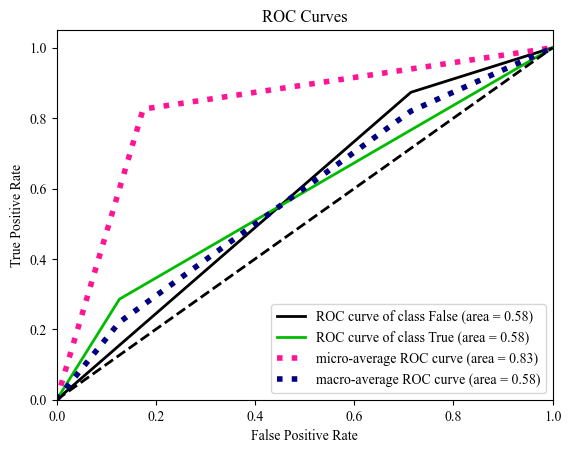

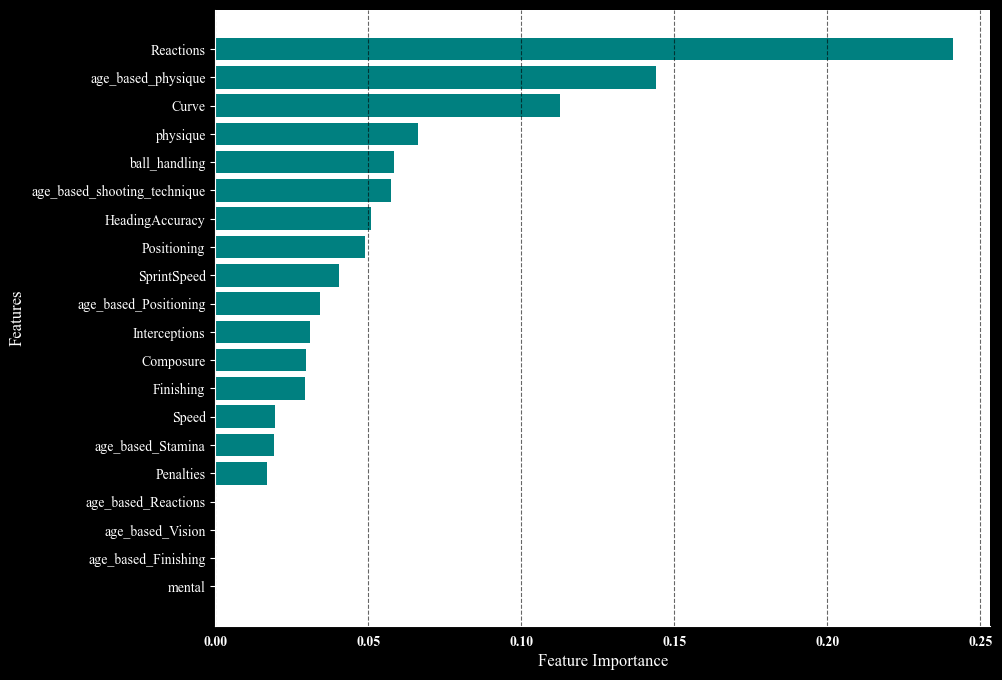

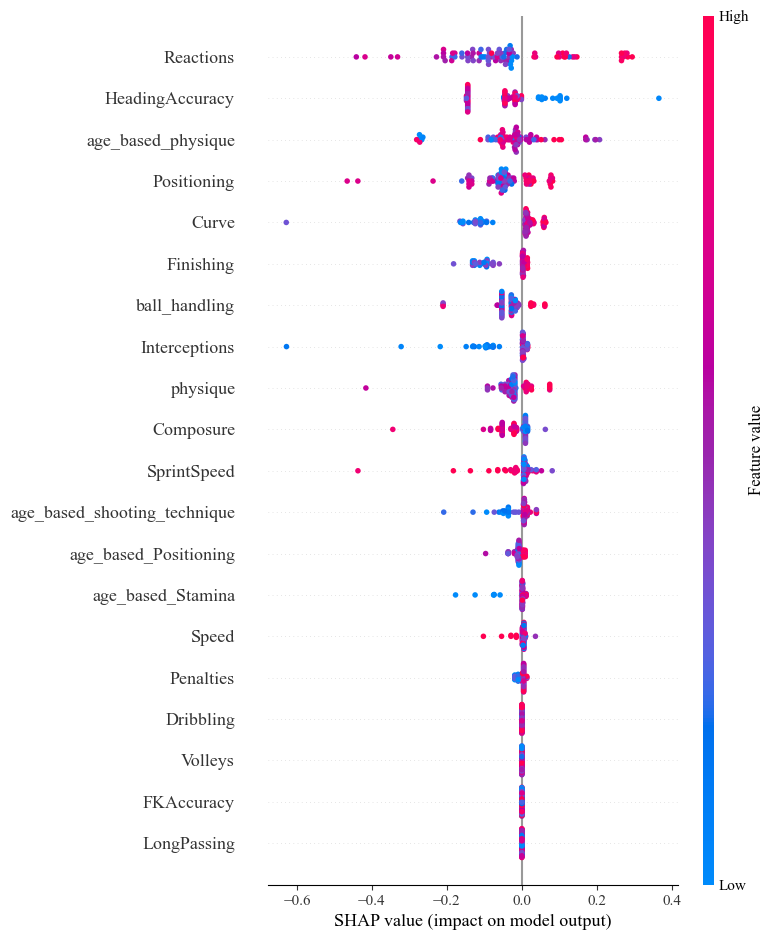

Random Forest Classifier training----->


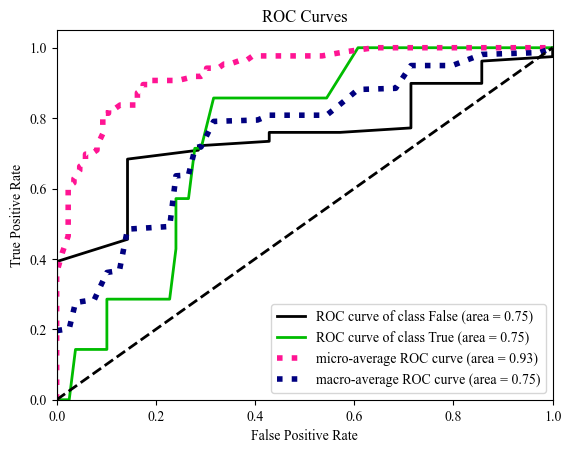

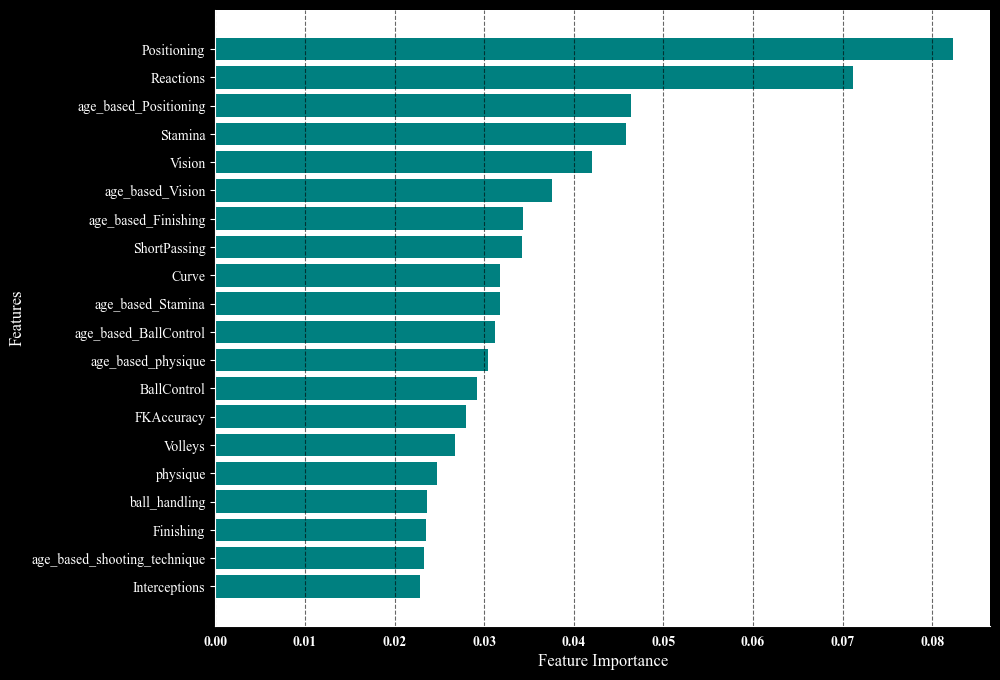

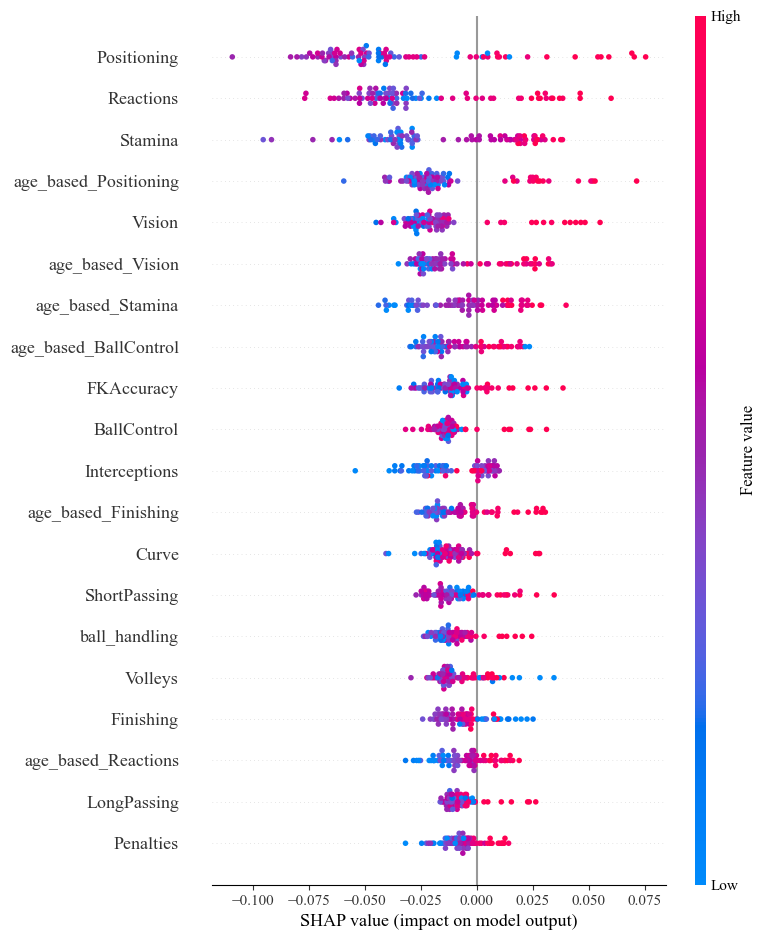

XGBoost Classifier training----->


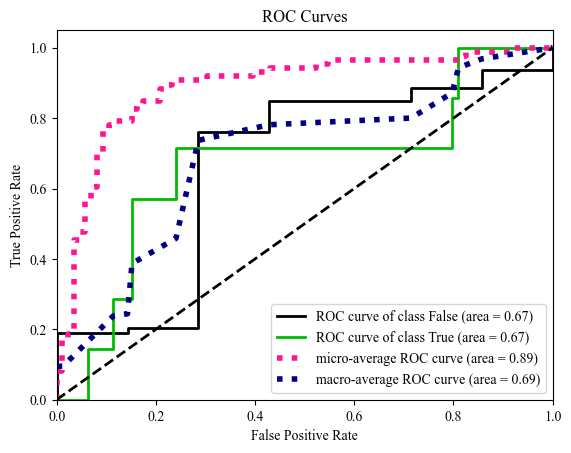

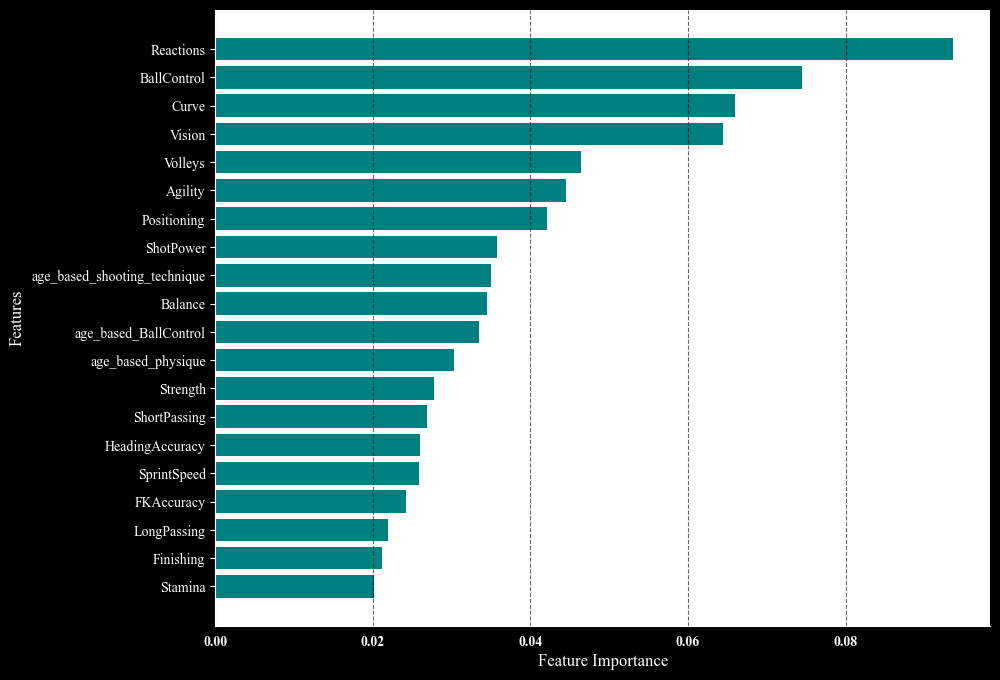

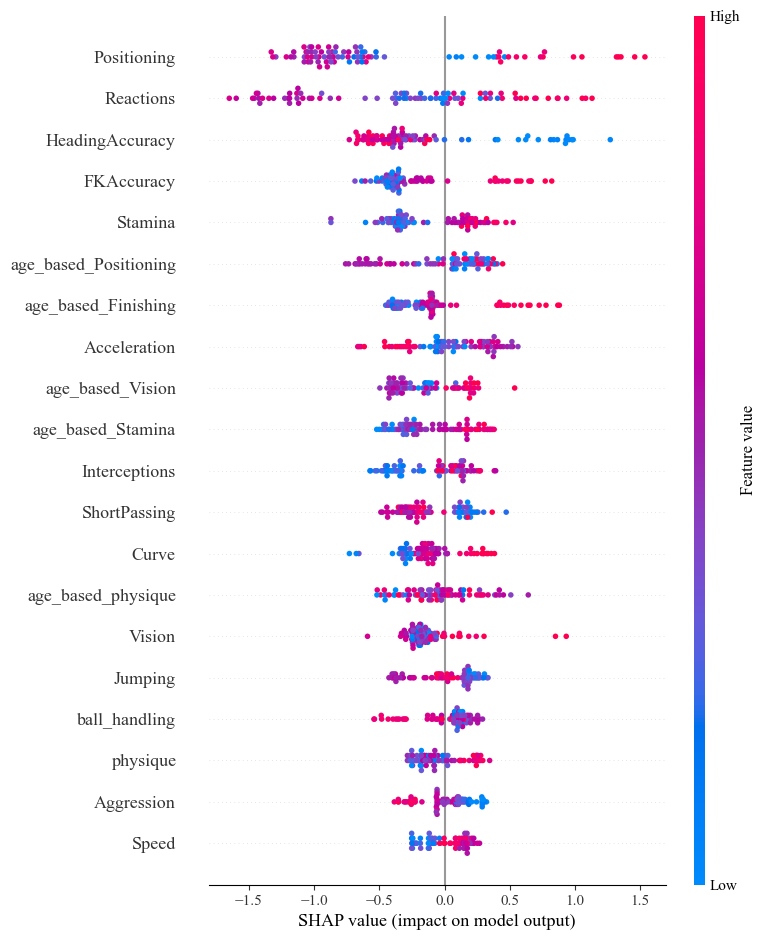

LightGBM Classifier training----->
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 47, number of negative: 94
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 141, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

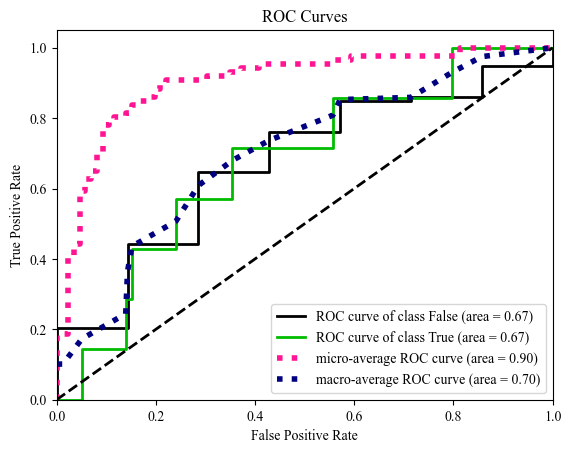

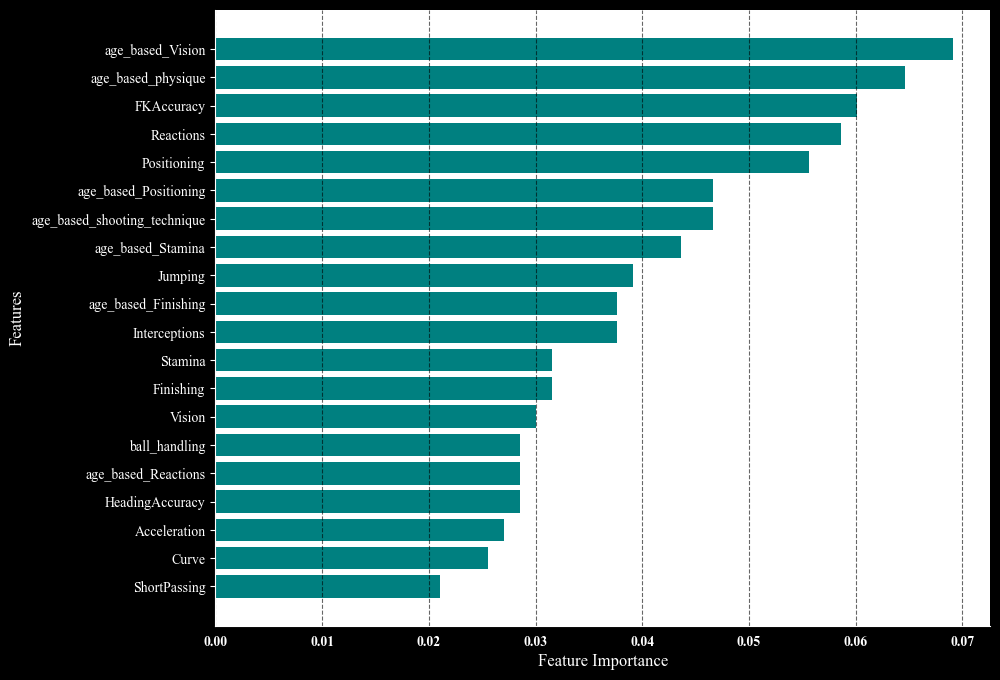

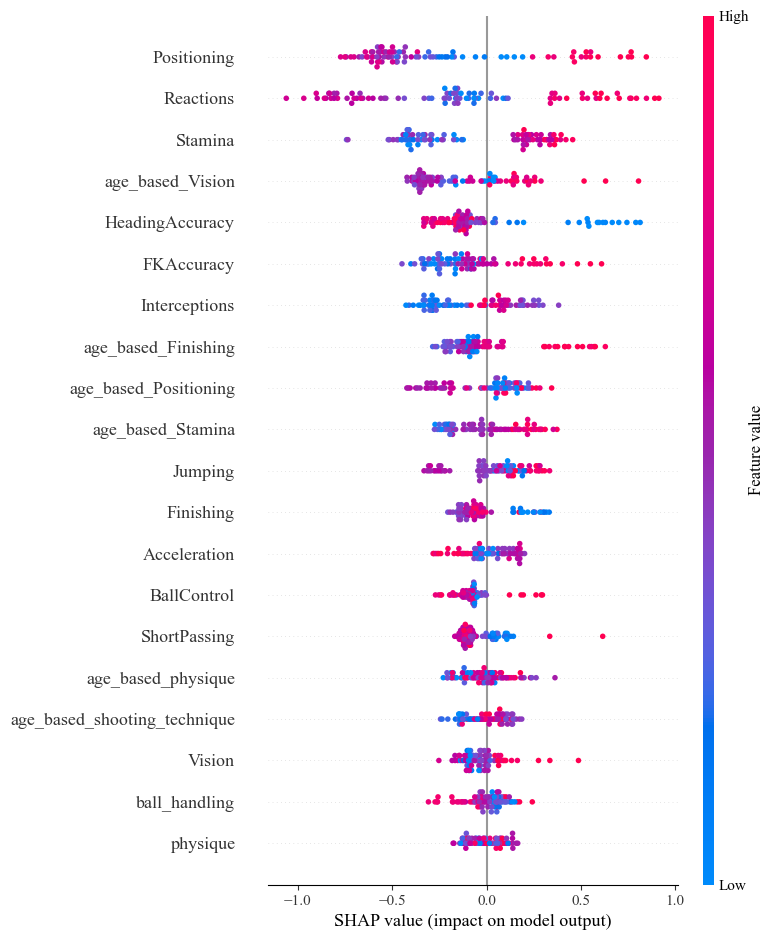

Model: Decision Tree Classifier
Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.87      0.90        79
        True       0.17      0.29      0.21         7

    accuracy                           0.83        86
   macro avg       0.55      0.58      0.56        86
weighted avg       0.87      0.83      0.85        86

Confusion Matrix:
[[69 10]
 [ 5  2]]
AUC: 0.58
Precision: 0.17

Model: Random Forest Classifier
Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.90      0.91        79
        True       0.11      0.14      0.12         7

    accuracy                           0.84        86
   macro avg       0.52      0.52      0.52        86
weighted avg       0.86      0.84      0.85        86

Confusion Matrix:
[[71  8]
 [ 6  1]]
AUC: 0.75
Precision: 0.11

Model: XGBoost Classifier
Accuracy: 0.84
Classification Report:
              

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from src.sport_analytics.model.eval import plot_feature_importance, plot_auc_curves,plot_shap_summary,log_metrics_in_mlflow,log_feature_list_as_artifact
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


# Create and train different classification models with class weights
models = {
    # 'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42,class_weight=CLASS_WEIGHTS, **PARAM_DT),
    'Random Forest Classifier': RandomForestClassifier(random_state=42,class_weight=CLASS_WEIGHTS, **PARAMS_RF),
    'XGBoost Classifier': xgb.XGBClassifier(random_state=42,**PARAM_XGB),
    # 'Support Vector Classifier': SVC(class_weight=class_weights, probability=True, kernel='linear'),
    # 'XGBoost Classifier': xgb.XGBClassifier(**PARAM_XGB),
    'LightGBM Classifier': lgb.LGBMClassifier(random_state=42,**{'n_estimators': 100, 'max_depth': 7, 'min_child_samples': 7,
                                                  'subsample': 0.8090291881142198, 'colsample_bytree': 0.6278496311554949,
                                                  'learning_rate': 0.17976777947590364, 'reg_alpha': 0.6699371890412207,
                                                  'reg_lambda': 1.5295937299896694})
}

model_results = {}

# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in models.items():
    with mlflow.start_run(run_name=RUN_NAME):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        model.fit(X_train_scaled_df, y_train)
        y_pred = model.predict(X_test_scaled_df)
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
        else:
            y_prob = None
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")
        
        # Create a dictionary with parameters and their values
        params_to_log = {
            'CLASS_WEIGHTS': CLASS_WEIGHTS,
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(PLAYER_ATTRIBUTES),
            'y_train_positives': y_train.sum(),
            'y_train_negatives': (~y_train).sum(),
            'y_test_positives': y_test.sum(),
            'y_test_negatives': (~y_test).sum(),
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)


        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Plots
        plot_auc_curves(y_true = y_test,y_proba = model.predict_proba(X_test_scaled_df))
        plot_feature_importance(model, '',top_n=20)
        plot_shap_summary(model=model,df=X_test_scaled_df)

        # Evaluation Metrics
        log_metrics_in_mlflow(y_test=y_test,y_prob=y_prob,y_pred=y_pred)


        # Output for quick evaluation
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision_pos, recall_pos, f1_pos, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1], average='binary')

        if y_prob is not None:
                roc_auc = roc_auc_score(y_test, y_prob)
        else:
            roc_auc = None
        
        
        model_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'attributes': PLAYER_ATTRIBUTES,
            'Accuracy': accuracy,
            'Classification Report': report,
            'Confusion Matrix': conf_matrix,
            'AUC': roc_auc,
            'recall':recall_pos,
            'f1':f1_pos,
            'Precision': precision_pos
        }


# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


# evaluate Model

In [124]:
my_model = model_results['Decision Tree Classifier']['Model']

false_positives = (my_model.predict_proba(X_test_scaled_df)[:,1]>0.5)&(~y_test)
X_test_scaled_df[false_positives]



,,,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Composure,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
243812,Rodrygo,2021,0.879673,0.722433,0.143093,0.615662,0.115526,0.962986,1.226827,1.260641,-0.052328,0.574695,0.792839,0.697164,0.991227,1.785968,0.880836,1.158159,-0.246966,0.589515,1.223945,-1.328152,0.406030,0.110574,-0.954579,1.324352,0.597452,0.965290,1.761105,-0.343400,0.779284,1.146323,2.226351,0.095802,1.207340,1.459937,1.105003,0.653623,0.543608,0.395948
255475,Antony,2021,0.232821,-0.374343,-1.161062,0.615662,-0.243793,0.962986,0.714286,1.415005,0.414649,1.216533,1.340160,1.139294,1.639478,1.633219,0.372349,1.158159,-0.514829,-0.819327,0.810093,-0.749937,0.276505,0.957144,0.836050,0.317702,1.288893,-0.024971,1.538143,-0.133565,1.297582,1.588125,0.042759,-0.153687,0.207807,0.559982,-0.383897,0.700242,-0.859735,0.396402
240950,Pedro Gonçalves,2022,1.122243,1.545015,-1.544637,1.905533,1.552801,0.815398,0.970556,1.183459,1.908974,1.216533,-0.712294,-0.776601,0.472626,1.908167,1.643566,1.345002,1.092349,-2.052063,1.637797,-0.388552,1.053658,0.816049,3.521995,1.450183,1.749855,0.965290,1.824808,0.548399,-0.775608,1.316247,1.885151,0.217681,2.694813,1.931641,2.473971,1.929851,2.524884,1.639238
245158,L. Suárez,2021,0.717960,1.407918,0.143093,-1.061171,-0.004247,-1.103247,0.372592,0.257274,0.041067,-0.869440,0.656009,0.697164,-0.045975,1.144423,0.499471,0.410789,0.422691,-0.379063,1.017019,1.346093,0.406030,1.944809,1.333448,0.569364,-0.670192,0.745232,1.394810,1.492656,0.705242,-0.484946,0.573295,1.052344,1.403335,0.823045,1.002544,-0.306983,1.981350,-0.350219
253072,D. Núñez,2022,0.475391,0.311142,0.986958,0.744649,0.115526,-0.808071,-0.139949,0.334456,-0.519305,-0.227602,0.382348,0.255035,-0.305276,1.633219,0.880836,-1.737901,1.360212,0.589515,1.741260,1.635201,0.276505,2.015357,1.035009,0.191870,1.173653,0.965290,1.681476,2.069702,0.335029,-0.994717,0.900632,1.721750,-0.340711,1.486962,-1.031494,0.924096,-1.071833,-0.888060
212623,Santi Mina,2019,0.960530,1.270821,0.756813,0.099713,0.474845,0.520222,0.287168,-0.128637,0.694835,0.574695,-0.575464,-0.039719,-0.175626,1.388821,1.135079,0.223946,0.690554,0.677568,0.603167,0.695601,0.794607,1.168787,2.129283,0.946858,-0.093990,-0.355058,1.362959,0.810692,-0.331353,0.398658,0.788643,0.071585,1.071075,-0.002928,0.909594,-0.787855,1.620784,0.047672
244193,Jovane Cabral,2021,0.960530,-0.237246,-0.240482,0.357688,0.953936,0.667810,0.885133,1.415005,0.788230,0.253776,0.656009,0.844541,0.861577,1.724868,0.626593,0.410789,0.824486,0.501463,0.085852,0.189663,0.794607,0.463312,-0.755620,0.317702,0.712692,0.085058,1.601846,0.181187,0.779284,0.636551,0.758540,-0.504415,1.868704,-0.296918,0.766481,1.096168,0.585609,0.622790
244267,A. Marin,2020,-0.656601,-2.019507,-1.467922,-0.545222,-1.681069,-0.217719,-0.310796,0.874730,0.227858,-0.869440,-0.164973,-0.481848,-0.823877,1.174973,-1.661597,-2.952378,-1.452349,-0.907379,-0.948778,-0.677660,-1.148275,-0.101068,0.338653,-1.821430,-0.209231,-2.885727,0.885183,-0.972905,-0.331353,-1.708397,-0.603783,-0.432804,0.071900,-0.239365,-0.935638,0.648426,-1.048571,0.165823
234742,H. Barnes,2020,0.717960,-0.511440,-1.467922,0.744649,-1.920615,-0.070131,0.372592,-0.360183,0.694835,-0.067143,-0.438633,-0.481848,-0.434926,1.297172,0.245228,0.317367,-0.246966,-0.819327,0.292778,-0.677660,0.924132,-0.383258,1.233968,0.191870,0.943173,-1.785436,1.108145,-0.343400,-0.479438,-0.043144,-0.105046,-0.617380,-0.660337,-0.151937,-0.364848,0.529698,-0.812368,-0.381628


In [125]:
false_negatives = (my_model.predict_proba(X_test_scaled_df)[:,1]<0.4)&(y_test)
X_test_scaled_df[false_negatives]

,,,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Composure,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
239085,E. Håland,2020,-1.222597,-0.100149,0.143093,-0.158261,0.474845,-0.808071,0.287168,-0.437365,-2.293816,-0.388062,-0.438633,0.255035,-1.731429,1.663769,0.118106,-0.710267,0.154829,0.325358,0.396241,1.490647,-0.759699,2.015357,0.438133,0.066039,-1.015913,0.745232,1.665550,1.282821,-0.109226,-1.062686,1.989649,2.244821,0.893140,1.378360,0.834841,-0.170079,0.579794,0.582827
232293,V. Osimhen,2020,0.232821,0.311142,1.140388,-0.287248,-0.004247,-1.398423,-0.567067,-1.363550,-0.799491,-0.869440,-0.575464,1.286670,-0.694227,1.358272,-0.390381,-0.430003,0.020897,1.293936,0.603167,0.984709,0.406030,1.309882,-0.158744,-0.059792,-0.439711,0.195087,1.426662,1.020527,0.335029,-1.028702,-0.526598,0.909641,-0.113107,0.509351,-0.204824,-0.626103,0.076745,-0.914913
210315,De Tomás,2020,-0.899171,1.133724,1.140388,0.486675,1.433028,-0.808071,-1.079607,1.260641,-0.519305,-0.227602,-1.670106,-1.218731,-0.953527,1.572120,0.880836,0.223946,1.494143,1.117831,-0.328000,1.129262,1.830810,0.110574,-0.855100,0.821027,-1.361634,1.075319,1.665550,0.653316,-1.516034,-0.450961,0.046950,0.428443,2.008341,-0.346575,1.193779,-1.434114,1.209667,0.741075
251566,Gabriel Martinelli,2021,0.394534,0.174045,0.603383,-0.158261,-0.603112,-0.217719,0.372592,-0.591729,-1.173072,-0.227602,0.656009,0.697164,0.472626,1.511020,0.245228,0.597631,-0.648760,-2.052063,0.706630,-0.171722,-1.018750,1.592072,0.637092,0.191870,-0.093990,-0.575116,1.394810,0.233646,0.705242,0.194750,1.300125,0.780776,-0.106643,0.837736,0.042715,-0.047952,0.078361,-0.299059
242444,João Félix,2019,0.232821,-1.882410,-1.544637,-0.029274,-0.243793,-0.070131,0.543439,-0.437365,0.321253,-0.067143,-0.712294,-0.481848,0.602276,1.358272,-0.517502,0.784474,-0.648760,-1.347642,0.396241,-2.267751,-2.184479,-0.101068,0.736571,-2.576418,0.251731,-1.345320,1.203700,-1.445034,-0.627523,0.398658,0.892707,-0.889942,-0.128740,1.423744,-1.557273,1.181715,-1.229196,1.034173
